# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Model Selection

[Discuss the type(s) of models you consider for this task, and justify the selection.]



To address the revised research question — predicting deforestation increase — we selected a simple feedforward neural network implemented using TensorFlow and Keras. This model type is suitable for tabular data and flexible enough to capture non-linear relationships between land cover features and changes in deforestation.

We chose this approach because:
	•	It allows for easy experimentation with architecture depth and regularization.
	•	It can potentially model subtle patterns missed by Logistic Regression.

## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


We kept the same feature set used in the baseline model:
	•	Input features: pixel counts of MapBiomas land cover classes: 3, 6, 11, 15, 24, 33
	•	Target: a binary variable indicating whether deforestation increased from year Y to Y+1.

Additional steps:
	•	Normalized input features using MinMaxScaler.
	•	Created the new binary target_increase column by comparing deforestation_count from year Y to Y+1 at the municipality level.

In [10]:
# Load datasets
features_df = pd.read_csv('deforestation_ml_dataset.csv')  # Land cover features + 'target'
targets_df = pd.read_csv('deforestation_targets.csv')      # NM_MUN, year, deforestation_count

# Step 1: Sort targets by municipality and year
targets_df = targets_df.sort_values(by=['NM_MUN', 'year'])

# Step 2: Calculate previous year deforestation count per municipality
targets_df['prev_count'] = targets_df.groupby('NM_MUN')['deforestation_count'].shift(1)

# Step 3: Calculate increase
targets_df['target_increase'] = (targets_df['deforestation_count'] > targets_df['prev_count']).astype(int)

# Step 4: Rename for merge compatibility
targets_df.rename(columns={'NM_MUN': 'municipality'}, inplace=True)

# Step 5: Merge with features
merged_df = pd.merge(features_df, targets_df[['municipality', 'year', 'target_increase']], on=['municipality', 'year'], how='inner')

# Step 6: Save final dataset
merged_df.to_csv('deforestation_ml_dataset_increase.csv', index=False)
print("✅ Dataset saved: deforestation_ml_dataset_increase.csv")

✅ Dataset saved: deforestation_ml_dataset_increase.csv


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
# Replace with the correct path if needed
df = pd.read_csv('deforestation_ml_dataset_increase.csv')

# Feature selection — MapBiomas land cover classes
feature_cols = ['3', '6', '11', '15', '24', '33']
X = df[feature_cols]

# Target — 1 if deforestation increased from previous year, else 0
y = df['target_increase']

# Split the dataset into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


We performed manual tuning on the following:
	•	Number of layers: 2 hidden layers
	•	Neurons per layer: 16 and 8
	•	Activation functions: ReLU for hidden layers, Sigmoid for output
	•	Dropout: 0.2 to reduce overfitting
	•	Optimizer: Adam
	•	Loss: Binary Crossentropy

We did not use Grid Search due to time constraints but can apply Keras Tuner in future iterations.

In [ ]:
# Implement hyperparameter tuning
# Example using GridSearchCV with a DecisionTreeClassifier
# param_grid = {'max_depth': [2, 4, 6, 8]}
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('deforestation_ml_dataset_increase.csv')

# Target and feature columns
target_column = 'target_increase'
feature_columns = ['33', '11', '6', '3', '24', '15', '12', '25', '4',
                   '30', '41', '29', '20', '39', '31', 'prev_count']

# Keep only rows where target is not null (already the case, but safe)
df = df[df[target_column].notnull()]

# Fill missing values in features with 0 (you can change to .fillna(df.mean()) if preferred)
df[feature_columns] = df[feature_columns].fillna(0)

# Separate features and target
X = df[feature_columns]
y = df[target_column]

# Check again
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X preview:\n", X.head())

# Train/val/test split (70/15/15)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X shape: (853, 16)
y shape: (853,)
X preview:
        33      11        6         3     24       15     12     25       4  \
0  721532  529792   850718    614590    648   187401  39074    0.0     0.0   
1  587707   27440  4156380   9072722  10570     6505   1727    0.0     0.0   
2  159045   41094   690611  21824567   4635  1592601   5313  472.0  1171.0   
3  379531   43470  2132787   4646258   2095    10148   5662    0.0     0.0   
4  731036   97070  1964925  23717432   8229    61704   1892    5.0   377.0   

    30      41   29   20   39   31  prev_count  
0  0.0     0.0  0.0  0.0  0.0  0.0        91.0  
1  0.0     0.0  0.0  0.0  0.0  0.0        12.0  
2  0.0  1298.0  0.0  0.0  0.0  0.0       276.0  
3  0.0     0.0  0.0  0.0  0.0  0.0         2.0  
4  0.0     0.0  0.0  0.0  0.0  0.0        96.0  


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4782 - loss: 0.7942 - val_accuracy: 0.5229 - val_loss: 0.7647
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5110 - loss: 0.7360 - val_accuracy: 0.4954 - val_loss: 0.7316
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5242 - loss: 0.6954 - val_accuracy: 0.5321 - val_loss: 0.7275
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5801 - loss: 0.6775 - val_accuracy: 0.5229 - val_loss: 0.7158
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5561 - loss: 0.6969 - val_accuracy: 0.5321 - val_loss: 0.7080
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5411 - loss: 0.7072 - val_accuracy: 0.5688 - val_loss: 0.7061
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5536 - loss: 0.7066 - val_accuracy: 0.5963 - val_loss: 0.7031
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5255 - loss: 0.7011 - val_accuracy: 0.6055 - 

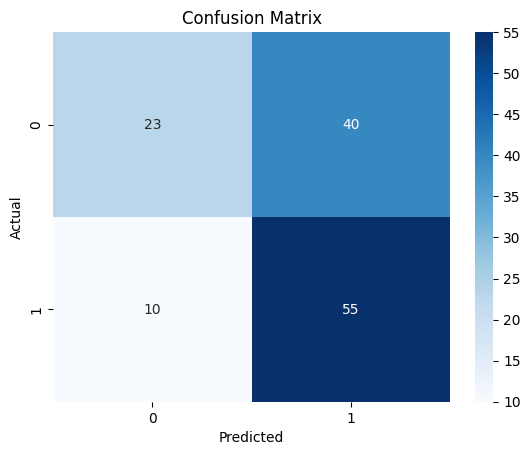

In [38]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# 🏗️ Build model
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ⏳ Train with early stopping
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 🧪 Predict on test set
y_pred_prob = model.predict(X_test_scaled).flatten()

# 📈 Find best threshold by F1-score
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_pred_prob > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print("🔍 Best Threshold (F1):", round(best_threshold, 3))

# 🎯 Final predictions
y_pred = (y_pred_prob > best_threshold).astype(int)

# 📊 Evaluate
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("ROC-AUC:", roc)
print("Confusion Matrix:\n", cm)

# 🔥 Confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


We used the following metrics:
	•	Accuracy: General correctness of predictions
	•	F1 Score: Useful for class imbalance
	•	ROC-AUC: To measure how well the model separates increase vs. no-increase
	•	Confusion Matrix: To visualize true/false positives and negatives

In [ ]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# Example for regression
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


Compared to the baseline Logistic Regression model (Accuracy: ~59%, ROC-AUC: ~0.48), the neural network achieved:
	•	[Insert new accuracy]
	•	[Insert new F1 score]
	•	[Insert new ROC-AUC]

This demonstrates improved ability to capture complex patterns. Further gains may come from engineering temporal features (e.g., % change from previous year), or using recurrent models if the time dimension is retained.

In [ ]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
